<a href="https://colab.research.google.com/github/Kopylovvadym/Kopylov-Vadym/blob/master/Lab_2_(Sigaev).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 12.8MB/s 
     |████████████████████████████████| 194kB 55.4MB/s 
     |████████████████████████████████| 1.1MB 59.5MB/s 
     |████████████████████████████████| 51kB 6.7MB/s 
     |████████████████████████████████| 61kB 9.1MB/s 
Mounted at /content/gdrive


In [5]:
#hide
from fastbook import *
from fastai.vision.widgets import *

Tabular data

In [6]:
key = os.environ.get('AZURE_SEARCH_KEY', '1f0a24b38e7b485e8b435f0645ba94fa')

In [7]:
search_images_bing

<function fastbook.search_images_bing>

In [8]:
results = search_images_bing(key, 'raccoon')
ims = results.attrgot('content_url')
len(ims)

150

In [9]:
#hide
ims = ['https://get.pxhere.com/photo/animal-wildlife-mammal-fauna-raccoon-vertebrate-cheeky-procyon-procyonidae-viverridae-1117354.jpg']

In [10]:
dest = 'C:\images\raccoon.jpg'
download_url(ims[0], dest)

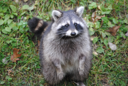

In [11]:
im = Image.open(dest)
im.to_thumb(128,128)

In [12]:
marsupials_types = 'raccoon','badger','lemur'
path = Path('marsupials')

In [13]:
if not path.exists():
    path.mkdir()
    for o in marsupials_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} marsupial')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [14]:
fns = get_image_files(path)
fns

(#370) [Path('marsupials/lemur/00000091.jpg'),Path('marsupials/lemur/00000060.jpg'),Path('marsupials/lemur/00000040.jpg'),Path('marsupials/lemur/00000120.jpg'),Path('marsupials/lemur/00000087.jpg'),Path('marsupials/lemur/00000073.jpg'),Path('marsupials/lemur/00000042.jpg'),Path('marsupials/lemur/00000072.png'),Path('marsupials/lemur/00000066.jpg'),Path('marsupials/lemur/00000108.jpg')...]

In [15]:
failed = verify_images(fns)
failed

(#5) [Path('marsupials/raccoon/00000097.jpg'),Path('marsupials/raccoon/00000110.jpg'),Path('marsupials/raccoon/00000104.jpg'),Path('marsupials/raccoon/00000142.jpg'),Path('marsupials/badger/00000092.png')]

In [16]:
failed.map(Path.unlink);

From Data to DataLoaders

In [17]:
marsupials = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [18]:
dls = marsupials.dataloaders(path)

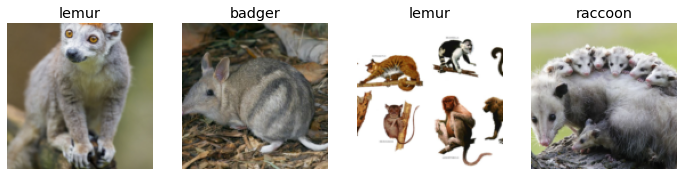

In [19]:
dls.valid.show_batch(max_n=4, nrows=1)

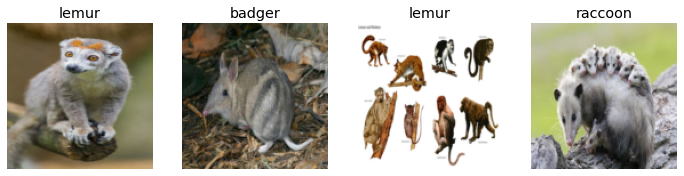

In [20]:
marsupials = marsupials.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = marsupials.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

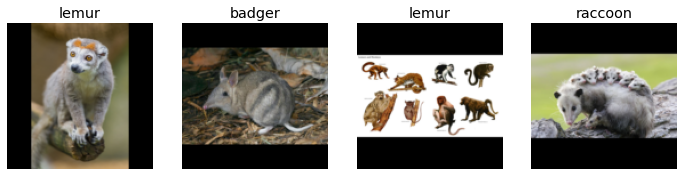

In [21]:
marsupials = marsupials.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = marsupials.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

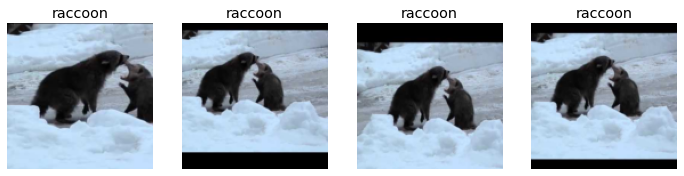

In [22]:
marsupials = marsupials.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = marsupials.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

Data Augmentation

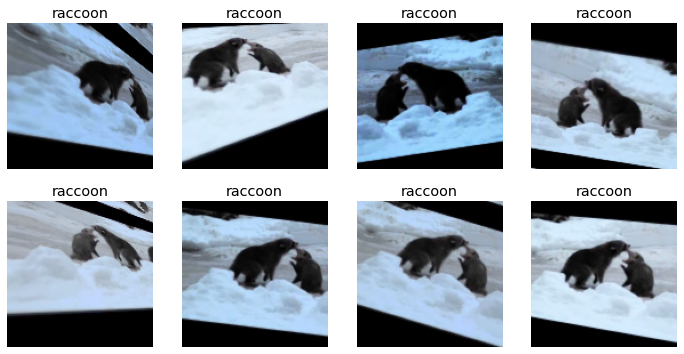

In [23]:
marsupials = marsupials.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = marsupials.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

Training Your Model, and Using It to Clean Your Data

In [24]:
marsupials = marsupials.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = marsupials.dataloaders(path)

In [25]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


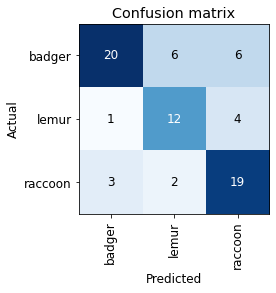

In [26]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

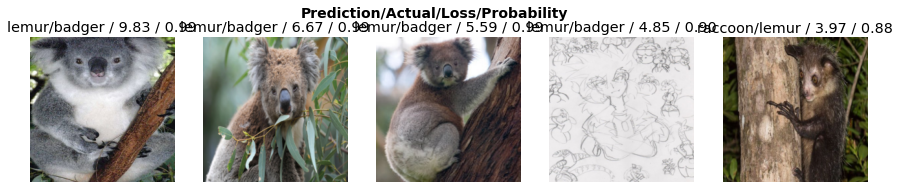

In [31]:
interp.plot_top_losses(5, nrows=1)

In [32]:
cleaner = ImageClassifierCleaner(learn)
cleaner

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [33]:
#hide
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

Turning Your Model into an Online Application

Using the Model for Inference

In [34]:
learn.export()

In [35]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [36]:
learn_inf = load_learner(path/'export.pkl')

In [37]:
learn_inf.predict('C:\images\raccoon.jpg')

('raccoon', tensor(2), tensor([0.0794, 0.0041, 0.9165]))

In [38]:
learn_inf.dls.vocab

['badger', 'lemur', 'raccoon']

Creating a Notebook App from the Model

In [39]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [40]:
#hide
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = ['C:\images\raccoon.jpg'])

In [41]:
img = PILImage.create(btn_upload.data[-1])

In [42]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [43]:
pred,pred_idx,probs = learn_inf.predict(img)

In [44]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: raccoon; Probability: 0.9165')

In [45]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [46]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [47]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [48]:
VBox([widgets.Label('Select your marsupial!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

Turning Your Notebook into a Real App

In [49]:
#hide
#!pip install nbconvert
#!pip install voila
#!jupyter serverextension enable --sys-prefix voila 